In [1]:
## Chris Kellogg

## ############################################################################
## ############################################################################
##
## The Decline of Javy Baez
##
## ############################################################################
## ############################################################################

##
## Javy Baez broke into Major League Baseball with the Chicago Cubs, and was
## a solid offensive performer for them for about 6 years. He turned down a
## significant contract extension offer from the Cubs and signed a large
## free-agent contract with the Tigers in 2021, marking the beginning of a
## tremendous decline in his offense.
##
## I’ll attempt to answer this question: Has a change in the way MLB pitchers
## approach Javy Baez accounted for his struggles in Detroit?
##

In [2]:
##
## load necessary packages
##

# import and alias Pandas
import pandas as pd

# import and alias NumPy
import numpy as np

# import and alias the plotting package
import matplotlib.pyplot as plt

# import from pybaseball API
import pybaseball
from pybaseball import  playerid_lookup
from pybaseball import  statcast_batter

# import Linear Regression tools
from sklearn.linear_model import LinearRegression

# suppress some warnings from pybaseball
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
##
## read and clean up Javy Báez's Season Batting Stats
## -- downloaded from Baseball Reference web page
## -- https://www.baseball-reference.com/players/b/baezja01.shtml
##

# read the Season Batting Stats file
seasons = pd.read_csv('BaezSeasonBatting.csv')

# start from when he became a full-time MLB player and
# drop the sub-total rows from the year he was traded
seasons = seasons.query(
    'Year not in (2014, 2015, 2021) or Tm == "TOT"'
)

# keep only the fields we want
seasons = pd.DataFrame(seasons[[
    'Year',
    'PA',
    'AB',
    'HR',
    'BB',
    'SO',
    'BA',
    'OBP',
    'SLG',
    'OPS',
    'OPS+'
]])

# preview the season batting stats
seasons

,Year,PA,AB,HR,BB,SO,BA,OBP,SLG,OPS,OPS+
2,2016,450,421,14,15,108,0.273,0.314,0.423,0.737,94
3,2017,508,469,23,30,144,0.273,0.317,0.480,0.796,102
4,2018,645,606,34,29,167,0.290,0.326,0.554,0.881,129
5,2019,561,531,29,28,156,0.281,0.316,0.531,0.847,115
6,2020,235,222,8,7,75,0.203,0.238,0.360,0.599,59
7,2021,547,502,31,28,184,0.265,0.319,0.494,0.813,117
10,2022,590,555,17,26,147,0.238,0.278,0.393,0.671,91
11,2023,547,510,9,24,125,0.222,0.267,0.325,0.593,63
12,2024,289,272,6,12,69,0.184,0.221,0.294,0.516,44


In [4]:
##
## get Javy Báez's MLBAM player ID
##

# look up player id
playerid_lookup('Báez', 'Javier')

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,báez,javier,595879,baezj001,baezja01,12979,2014.0,2024.0


In [5]:
##
## get a list all regular-season pitches thrown to Javy Báez in his career
## (save a "golden record" copy so it's easier to reset during EDA)
##

# get data from the pybaseball API
javy_baez_career = statcast_batter('2016-01-01', '2024-12-31', 595879)

# keep only the pitches thrown during regular-season games
pitches = pd.DataFrame(javy_baez_career.query('game_type == "R"'))

# mark pitches as fastballs and curveballs where appropriate
pitches['fastball'] = pitches['pitch_type'].apply(
    lambda x: 1 if x in ("FF", "SI", "FC") else 0
)
pitches['breaking_ball'] = pitches['pitch_type'].apply(
    lambda x: 1 if x in ("CU", "KC", "CS", "SL", "ST", "SV") else 0
)

# save a "golden record" copy so it's easier to reset during EDA
pristine_pitches = pitches.copy()

# preview the pitches
pitches = pristine_pitches.copy()
pitches

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,fastball,breaking_ball
0,SL,2021-10-01,84.6,-1.30,6.22,"Báez, Javier",595879,660623,field_out,hit_into_play,...,6.0,1.0,11.0,NaN,3.57,-0.18,-0.18,42.3,0,1
1,FF,2021-10-01,96.6,-0.50,6.70,"Báez, Javier",595879,660623,None,foul,...,6.0,1.0,11.0,NaN,0.93,0.52,0.52,56.3,1,0
2,FF,2021-10-01,97.7,-0.16,6.74,"Báez, Javier",595879,660623,strikeout,called_strike,...,6.0,1.0,11.0,NaN,1.03,0.68,0.68,61.0,1,0
3,SL,2021-10-01,85.5,-1.37,6.16,"Báez, Javier",595879,660623,None,foul,...,6.0,1.0,11.0,NaN,3.28,-0.23,-0.23,41.6,0,1
4,SL,2021-10-01,85.7,-1.08,6.16,"Báez, Javier",595879,660623,None,foul,...,6.0,1.0,11.0,NaN,3.47,-0.10,-0.10,42.3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5390,SL,2022-04-08,78.3,-1.62,4.95,"Báez, Javier",595879,605195,None,swinging_strike,...,NaN,NaN,2.0,1.0,3.48,-1.55,-1.55,15.5,0,1
5391,FF,2022-04-08,92.2,-1.22,6.36,"Báez, Javier",595879,608337,None,foul,...,NaN,NaN,16.0,1.0,1.01,0.29,0.29,64.4,1,0
5392,FF,2022-04-08,92.4,-1.21,6.37,"Báez, Javier",595879,608337,None,swinging_strike,...,NaN,NaN,16.0,1.0,1.22,0.28,0.28,62.3,1,0
5393,SI,2022-04-08,91.5,-1.26,4.94,"Báez, Javier",595879,605195,None,ball,...,NaN,NaN,2.0,1.0,2.56,1.30,1.30,16.8,1,0


In [6]:
##
## keep only the pitch data fields we want
##

# copy the "golden record" pitch data
pitches = pristine_pitches.copy()

# retain only the interesting fields
pitches = pd.DataFrame(pitches[[
    'game_year',
    'pitch_type',
    'fastball',
    'breaking_ball',
    'release_speed',
    'release_spin_rate',
    'balls',
    'strikes',
    'zone',
    'pitch_number',
    'description'
]])

# rename the game_year column for joining
pitches.rename(columns={'game_year': 'Year'}, inplace=True)

# preview the pitches data
pitches

,Year,pitch_type,fastball,breaking_ball,release_speed,release_spin_rate,balls,strikes,zone,pitch_number,description
0,2021,SL,0,1,84.6,2427.0,0,1,2.0,2,hit_into_play
1,2021,FF,1,0,96.6,2035.0,0,0,5.0,1,foul
2,2021,FF,1,0,97.7,2107.0,1,2,14.0,6,called_strike
3,2021,SL,0,1,85.5,2407.0,1,2,9.0,5,foul
4,2021,SL,0,1,85.7,2320.0,1,2,14.0,4,foul
...,...,...,...,...,...,...,...,...,...,...,...
5390,2022,SL,0,1,78.3,2952.0,1,0,12.0,2,swinging_strike
5391,2022,FF,1,0,92.2,2083.0,1,1,11.0,3,foul
5392,2022,FF,1,0,92.4,2133.0,1,0,11.0,2,swinging_strike
5393,2022,SI,1,0,91.5,2086.0,0,0,14.0,1,ball


In [7]:
##
## get the aggregate info for all pitches
##

# get the count for each year
pitch_data = pitches \
    .groupby(['Year']) \
    .agg(
        pitch_count = ('pitch_type', 'count')
    ) \
    .reset_index()

# preview the pitches data
pitch_data

,Year,pitch_count
0,2016,1683
1,2017,1840
2,2018,2232
3,2019,1985
4,2020,914
5,2021,2072
6,2022,2093
7,2023,1963
8,2024,1020


In [8]:
##
## get the aggregate info for fastballs
##

# get the mean velocity and count for each year
fastball_data = pitches \
    .query('fastball == 1') \
    .groupby(['Year']) \
    .agg(
        mean_fb_velo = ('release_speed', 'mean'),
        fb_count = ('pitch_type', 'count')
    ) \
    .reset_index()

# preview the fastball data
fastball_data

,Year,mean_fb_velo,fb_count
0,2016,92.812082,927
1,2017,93.116415,993
2,2018,92.872194,1194
3,2019,93.033424,1101
4,2020,92.645397,478
5,2021,93.222592,1111
6,2022,92.772956,954
7,2023,93.216306,1018
8,2024,93.280591,474


In [9]:
##
## get the aggregate info for breaking balls
##

# get the mean spin rate and count for each year
breaking_ball_data = pitches \
    .query('breaking_ball == 1') \
    .groupby(['Year']) \
    .agg(
        mean_bb_spin = ('release_spin_rate', 'mean'),
        bb_count = ('pitch_type', 'count')
    ) \
    .reset_index()

# preview the breaking ball data
breaking_ball_data

,Year,mean_bb_spin,bb_count
0,2016,2343.246696,564
1,2017,2378.603741,628
2,2018,2404.890039,837
3,2019,2485.948678,690
4,2020,2545.185915,362
5,2021,2473.761836,699
6,2022,2467.678490,875
7,2023,2455.187679,699
8,2024,2487.671946,442


In [10]:
##
## merge the aggregates to the season data
##

# add pitch data onto the season data
df = pd.merge(
    seasons,
    pitch_data,
    how = 'left',
    on = ['Year']
)

# add fastball data onto the season data
df = pd.merge(
    df,
    fastball_data,
    how = 'left',
    on = ['Year']
)

# add breaking ball data onto the list of 1000-pitch seasons
df = pd.merge(
    df,
    breaking_ball_data,
    how = 'left',
    on = ['Year']
)

# add columns for fastballs and breaking balls as percentage
df['fb_percent'] = df.fb_count / df.pitch_count
df['bb_percent'] = df.bb_count / df.pitch_count

# add column for what number season in MLB
df['season'] = df.Year - 2015

# keep only the fields we want
df = pd.DataFrame(df[[
    'Year',
    'season',
    'PA',
    'BA',
    'OBP',
    'OPS',
    'OPS+',
    'mean_fb_velo',
    'mean_bb_spin',
    'pitch_count',
    'fb_count',
    'fb_percent',
    'bb_count',
    'bb_percent'
]])

df

,Year,season,PA,BA,OBP,OPS,OPS+,mean_fb_velo,mean_bb_spin,pitch_count,fb_count,fb_percent,bb_count,bb_percent
0,2016,1,450,0.273,0.314,0.737,94,92.812082,2343.246696,1683,927,0.550802,564,0.335116
1,2017,2,508,0.273,0.317,0.796,102,93.116415,2378.603741,1840,993,0.539674,628,0.341304
2,2018,3,645,0.290,0.326,0.881,129,92.872194,2404.890039,2232,1194,0.534946,837,0.375000
3,2019,4,561,0.281,0.316,0.847,115,93.033424,2485.948678,1985,1101,0.554660,690,0.347607
4,2020,5,235,0.203,0.238,0.599,59,92.645397,2545.185915,914,478,0.522976,362,0.396061
5,2021,6,547,0.265,0.319,0.813,117,93.222592,2473.761836,2072,1111,0.536197,699,0.337355
6,2022,7,590,0.238,0.278,0.671,91,92.772956,2467.678490,2093,954,0.455805,875,0.418060
7,2023,8,547,0.222,0.267,0.593,63,93.216306,2455.187679,1963,1018,0.518594,699,0.356088
8,2024,9,289,0.184,0.221,0.516,44,93.280591,2487.671946,1020,474,0.464706,442,0.433333


In [11]:
##
## look for correlations between pitch data and offensive performance
##

pd.DataFrame.corr(df)[[
    'mean_fb_velo',
    'mean_bb_spin',
    'pitch_count',
    'fb_count',
    'fb_percent',
    'bb_count',
    'bb_percent'
]].drop([
    'mean_fb_velo',
    'mean_bb_spin',
    'pitch_count',
    'fb_count',
    'fb_percent',
    'bb_count',
    'bb_percent'
])

,mean_fb_velo,mean_bb_spin,pitch_count,fb_count,fb_percent,bb_count,bb_percent
Year,0.431885,0.673052,-0.238171,-0.382580,-0.746553,-0.051624,0.636942
season,0.431885,0.673052,-0.238171,-0.382580,-0.746553,-0.051624,0.636942
PA,0.112292,-0.433332,0.993321,0.956663,0.219556,0.958385,-0.421142
BA,-0.111028,-0.627027,0.768107,0.862739,0.688462,0.595010,-0.725409
OBP,-0.025980,-0.633817,0.799106,0.889807,0.683528,0.607976,-0.776105
OPS,-0.088416,-0.444689,0.718718,0.817658,0.670630,0.560016,-0.649217
OPS+,-0.102092,-0.431631,0.795636,0.858708,0.558979,0.672572,-0.585052


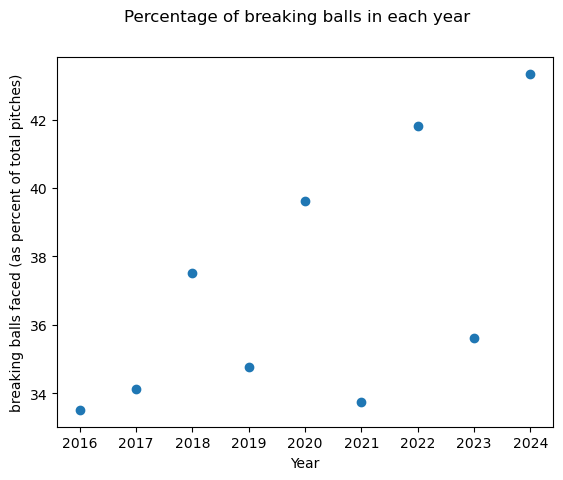

In [12]:
##
## visualize breaking ball percentage over Baez's career
##

# plot the percentage of breaking balls in each year
plt.scatter(df.Year, 100*df.bb_percent)

# add a chart title
plt.suptitle('Percentage of breaking balls in each year')

# add the x-axis label
plt.xlabel('Year')
plt.ylabel('breaking balls faced (as percent of total pitches)')

# show plot
plt.show()

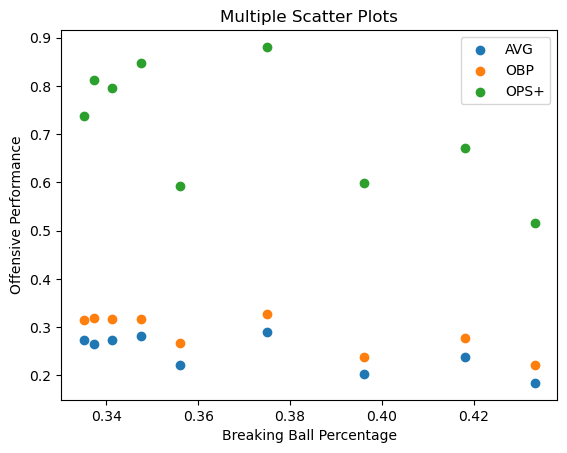

In [13]:
##
## visualize the relationship of breaking ball percentage
## with each of the offensive statistics
##

# Create the figure and axes object
fig, ax = plt.subplots()

# Plot the scatter plots
ax.scatter(df.bb_percent, df['BA'], label='AVG')
ax.scatter(df.bb_percent, df['OBP'], label='OBP')
ax.scatter(df.bb_percent, df['OPS'], label='OPS+')

# Add labels, title, and legend
ax.set_xlabel('Breaking Ball Percentage')
ax.set_ylabel('Offensive Performance')
ax.set_title('Multiple Scatter Plots')
ax.legend()

# Show the plot
plt.show()

In [14]:
##
## define a function to calculate and plot a linear regression fit
## given the statistic from the database
##

def my_function(stat, label):

    # define the feature and the target
    X = 100*df[['bb_percent']]
    Y = df[stat]
    
    # fit a linear regression
    model = LinearRegression()
    model.fit(X, Y)
    
    # print the intercept and coefficient
    print(f"{label} Intercept: {model.intercept_}")
    print(f"{label} Coefficient: {model.coef_}\n")
    
    # plot the actual data points
    plt.scatter(X, Y, label=label)
    
    # plot the regression line
    plt.plot(X, model.predict(X), alpha=0.6, linewidth=0.5)

AVG Intercept: 0.5226898459884539
AVG Coefficient: [-0.00741097]

OBP Intercept: 0.5947721207645664
OBP Coefficient: [-0.00825452]

OPS Intercept: 1.5570036368011748
OPS Coefficient: [-0.02263534]



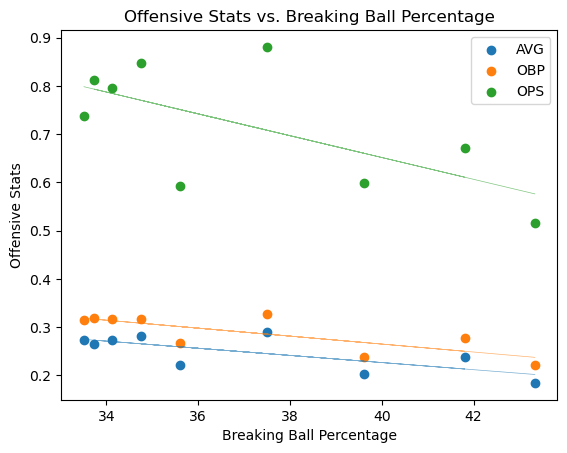

In [15]:
##
## plot the linear regression fit for the offensive stats
##

# add the data points and regression fit for each stat
my_function('BA', 'AVG')
my_function('OBP', 'OBP')
my_function('OPS', 'OPS')

# add labels and title
plt.xlabel('Breaking Ball Percentage')
plt.ylabel('Offensive Stats')
plt.title('Offensive Stats vs. Breaking Ball Percentage')
plt.legend()

# display the graphic
plt.show()